In [2]:
# Import Packages:
from __future__ import print_function

import os, sys
from six.moves import cPickle as pickle
from six.moves import range
from collections import defaultdict

# Model Packeges import
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Get the current working directory
cwd = os.getcwd()
mydir = os.path.abspath(os.path.join(cwd, ".."))
sys.path.append(mydir)
from DataGenerator import genTrainValidFolds

# Packages for plot:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline


In [13]:
# def toOneHotVector():
def reset_graph():  # Reset the graph
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    
    
def reshape_data(dataset, labels, featureSize, numLabels, sample_size=None):
    if sample_size:
        dataset = dataset[:sample_size].reshape(sample_size, featureSize) # To reshape the  
        # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
        labels = (np.arange(numLabels) == labels[:,None]).astype(np.float32)
    else:
        dataset = dataset.reshape(len(dataset), featureSize) # To reshape the  
        # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
        labels = (np.arange(numLabels) == labels[:,None]).astype(np.float32)
    return dataset, labels


def accuracy(predictions, labels):
    # Both the predictions and the labels should be in One-Hot vector format.
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])


def confusionMatrix(predictions, labels):
    # Both the predictions and the labels should be in One-Hot vector format.
    return (pd.crosstab(np.argmax(labels, 1), np.argmax(predictions, 1), rownames=['True'], colnames=['Predicted'], margins=True))

def vizualize(validacc_dict, trainacc_dict, meanValidAcc, rows, columns, figsize=(40,20), xlabels=None, ylabels=None, titles=None):
    fig1, axs = plt.subplots(rows, columns, figsize=figsize, facecolor='w', edgecolor='k')   # 
    axs = axs.ravel()
    numFolds = len(validacc_dict.keys())
    for foldNum in np.arange(numFolds):
        axs[foldNum].plot(validacc_dict[foldNum+1])
        axs[foldNum].plot(trainacc_dict[foldNum+1])
        axs[foldNum].axhline(y=meanValidAcc, color = 'k')
        axs[foldNum].set_title('Validation/Training accuracy Fold:%s '%str(foldNum+1))
        axs[foldNum].legend(['validation acc', 'training acc', ['n-fold avg valid acc']], loc=4)


In [4]:
class BuildNeuralNet():
    
    def __init__(self, params, featureSize):
        print (params)
        self.imageSize = params['imageSize']
        self.numLabels = params['numLabels']
        
        # Network params
        self.numHidden1 = params['numHidden1']
        self.numHidden2 = params['numHidden2']
        self.numHidden3 = params['numHidden3'] 
        
        # Batch Variables
        self.numFolds = params['numFolds']
        self.epochs = params['epochs']
        self.batchSize = params['batchSize']
        
        # Optimization Params
        self.keepProb = params['keepProb']
        self.optimizerParam = params['optimizerParam']
        
        self.featureSize = featureSize
#         print (self.featureSize)
#         print (self.numHidden1)
        
        self.weights = {
            "hid1_wght": tf.Variable(tf.random_normal([self.featureSize, self.numHidden1], seed=1877)),
            "hid2_wght" : tf.Variable(tf.random_normal([self.numHidden1, self.numHidden2], seed=74698)),
            "hid3_wght": tf.Variable(tf.random_normal([self.numHidden2, self.numHidden3], seed=9036)),
#             "hid4_wght": tf.Variable(tf.random_normal([self.numHidden3, self.numHidden4], seed=9476)),
            "out_wght": tf.Variable(tf.random_normal([self.numHidden3, self.numLabels], seed=5664))
        }
        
        self.biases = {
            "hid1_bias": tf.Variable(tf.random_normal([self.numHidden1], seed=6353)),
            "hid2_bias": tf.Variable(tf.random_normal([self.numHidden2], seed=7476)),
            "hid3_bias": tf.Variable(tf.random_normal([self.numHidden3], seed=1322)),
#             "hid4_bias": tf.Variable(tf.random_normal([self.numHidden4], seed=8722)),
            "out_bias": tf.Variable(tf.random_normal([self.numLabels], seed=2228))
        }
        
    def hiddenLayer(self, x, w, b, keepProb=None, nlModel='RELU'):
        x = tf.matmul(x, w) + b
        if nlModel == 'RELU':
            x = tf.nn.relu(x)
        elif nlModel == 'LOGIT':
            x = tf.sigmoid(x)
            
        if keepProb:
            return tf.nn.dropout(x, keepProb)
        else: return x
        
        
    def outputLayer(self, x, w, b):
        x = tf.matmul(x, w) + b
        return x, tf.nn.softmax(x)
        
        
    def trainGraph(self, regularization=False):
        trainData = tf.placeholder(tf.float32, [None, self.featureSize])
        trainLabels = tf.placeholder(tf.float32, [None, self.numLabels])

        # 1st Hidden Layer State
        hid1State = self.hiddenLayer(x=trainData, w=self.weights['hid1_wght'], b=self.biases['hid1_bias'], keepProb=self.keepProb['hid1'], nlModel='RELU') 
        
        # 2nd Hidden Layer State
        hid2State = self.hiddenLayer(x=hid1State, w=self.weights['hid2_wght'], b=self.biases['hid2_bias'], keepProb=self.keepProb['hid2'], nlModel='RELU') 
        
        # 3nd Hidden Layer State
        hid3State = self.hiddenLayer(x=hid2State, w=self.weights['hid3_wght'], b=self.biases['hid3_bias'], keepProb=self.keepProb['hid3'], nlModel='RELU') 
        
        # 4rth Hidden Layer State
        # hid4State = self.hiddenLayer(x=hid2State, w=self.weights['hid4_wght'], b=self.biases['hid4_bias'], dropoutProb=0.75, nlModel='RELU') 
        
        # Output Layer State
        hidToOut, outState = self.outputLayer(x=hid3State, w=self.weights['out_wght'], b=self.biases['out_bias'])
        
        # Loss Function
        lossCE = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hidToOut, labels=trainLabels))
        
        # Loss function using L2 Regularization
        if regularization:
            print ('Doing L2 Regularization')
            regularizers = (tf.nn.l2_loss(self.weights['hid1_wght']) 
                            + tf.nn.l2_loss(self.weights['hid2_wght']) 
                            + tf.nn.l2_loss(self.weights['hid3_wght']) 
                            + tf.nn.l2_loss(self.weights['out_wght'])
                        )
            lossCE = tf.reduce_mean(lossCE + (0.005 * regularizers))
        
        
        # Optimizer
        if self.optimizerParam['optimizer'] == 'ADAM': 
            optimizer = tf.train.AdamOptimizer(learning_rate=self.optimizerParam['learning_rate']).minimize(lossCE)   # 0.008
        elif self.optimizerParam['optimizer'] == 'MOMENTUM':
             optimizer = tf.train.MomentumOptimizer(learning_rate=self.optimizerParam['learning_rate'],               # l=0.004, m=0.5
                                                    momentum=self.optimizerParam['momentum'], 
                                                    use_locking=False, name='Momentum', use_nesterov=False).minimize(lossCE)
        elif self.optimizerParam['optimizer'] == 'SGD':                                                              # 0.001
            optimizer = tf.train.GradientDescentOptimizer(self.optimizerParam['learning_rate']).minimize(lossCE)
        elif self.optimizerParam['optimizer'] == 'ADAGRAD':
            optimizer = tf.train.AdagradOptimizer(learning_rate=self.optimizerParam['learning_rate']).minimize(lossCE)  # 0.04
        elif self.optimizerParam['optimizer'] == 'RMSPROP':
            optimizer = tf.train.RMSPropOptimizer(learning_rate=self.optimizerParam['learning_rate'],                # 0.001
                                                  momentum=self.optimizerParam['momentum']).minimize(lossCE)
        else:
            print ("Your provided optimizers do not match with any of the initialized optimizers: .........")
            return None
        
        # Evaluate model
#         trainPred = tf.equal(tf.argmax(outState, 1), tf.argmax(trainLabels, 1))
#         trainAccuracy = tf.reduce_mean(tf.cast(trainPred, tf.float32))
        
        return dict(
            trainData = trainData, 
            trainLabels = trainLabels,
            trainPred = outState,
            optimizer = optimizer,
            lossCE = lossCE,
            wghtNew = self.weights
        )
    
    
    def validGraph(self):

        validData = tf.placeholder(tf.float32, [None, self.featureSize])
        validLabels = tf.placeholder(tf.float32, [None, self.numLabels])

        # 1st Hidden Layer State
        vhid1State = self.hiddenLayer(x=validData, w=self.weights['hid1_wght'], b=self.biases['hid1_bias'], nlModel='RELU')

        # 2nd Hidden Layer State
        vhid2State = self.hiddenLayer(x=vhid1State, w=self.weights['hid2_wght'], b=self.biases['hid2_bias'], nlModel='RELU')

        # 3nd Hidden Layer State
        vhid3State = self.hiddenLayer(x=vhid2State, w=self.weights['hid3_wght'], b=self.biases['hid3_bias'], nlModel='RELU')
        
        # 4th Hidden Layer State
        # vhid4State = self.hiddenLayer(x=vhid3State, w=self.weights['hid4_wght'], b=self.biases['hid4_bias'], nlModel='RELU')

        # Output Layer State
        _, validOutState = self.outputLayer(x=vhid3State, w=self.weights['out_wght'], b=self.biases['out_bias'])

        return dict(
            validData = validData,
            validLabels = validLabels,
            validPred = validOutState
        )



In [5]:
class SessionExec():
    
    def __init__(self, featureDIR, params):
        self.featureDIR = featureDIR
        
        self.numFolds = params['numFolds']
        self.epochs = params['epochs']
        self.batchSize = params['batchSize']
        self.imageSize = params['imageSize']
        
        self.prevWghtDict = {}
        self.wghtChngDict = defaultdict(list)
        self.meanValidAcc = 0
        self.loss_PerEpoch_PerFold = defaultdict(list)
        self.trainacc_PerEpoch_PerFold = defaultdict(list)
        self.validacc_PerEpoch_PerFold = defaultdict(list)
        
        
        
    def captureWghtChange(self, wghtDict):   
        for layer, wght_arr in wghtDict.items():
#             print (layer)
#             print (np.sum(np.abs(wght_arr-self.prevWghtDict[layer])))
#             print ('********************')
            self.wghtChngDict[layer].append(np.sum(np.abs(wght_arr-self.prevWghtDict[layer])))
    
    
    
    def trainModel(self, trainDataIN, trainLabelsIN, sess):    
        numBatches = int(trainDataIN.shape[0]/self.batchSize)
        for numBatch in np.arange(numBatches):
#                     print ('Batch no: ', numBatch)
#                     print (numBatch*self.batchSize,  (numBatch+1)*self.batchSize)
            batchData = trainDataIN[numBatch*self.batchSize : (numBatch+1)*self.batchSize]
            batchLabels = trainLabelsIN[numBatch*self.batchSize : (numBatch+1)*self.batchSize]

            feed_dict = {self.trainGraphDict['trainData']: batchData,
                         self.trainGraphDict['trainLabels']: batchLabels
#                              self.trainGraphDict['keep_prob']: 0.7
                    }

            _, loss, tpred, wght = sess.run([self.trainGraphDict['optimizer'],
                                        self.trainGraphDict['lossCE'],
                                        self.trainGraphDict['trainPred'],
                                        self.trainGraphDict['wghtNew']], feed_dict=feed_dict)
            
            if any(self.prevWghtDict):
                self.captureWghtChange(wght)
                self.prevWghtDict = wght
            else:
                self.prevWghtDict = wght
                
                
            if ((numBatch+1)%10 == 0) or ((numBatch+1) == numBatches): 
                tacc = accuracy(tpred, batchLabels)
                print ("Fold: " + str(self.foldNUM+1) + 
                       ", Epoch: " + str(self.epoch+1)+ 
                       ", Mini Batch: " + str(numBatch+1) + 
                       ", Loss= " + "{:.6f}".format(loss) + 
                       ", Training Accuracy= " + "{:.5f}".format(tacc))
    
        return loss, tacc
    
    
    def validModel(self, validDataIN, validLabelsIN, sess):
        feed_dict = {self.validGraphDict['validData']: validDataIN,
                     self.validGraphDict['validLabels']: validLabelsIN
#                              self.trainGraphDict['keep_prob']: 0.7
                }

        vpred = sess.run(self.validGraphDict['validPred'], feed_dict=feed_dict)
        
        vacc = accuracy(vpred, validLabelsIN)
        print ("Fold: " + str(self.foldNUM+1) + 
                ", Epoch: " + str(self.epoch+1)+ 
                ", Validation Accuracy= " + "{:.5f}".format(vacc))
        
        return vpred, vacc 
        
        
    def execute(self):
        meanValidAcc = 0
        
        for foldNUM, (trainDataIN, trainLabelsIN, validDataIN, validLabelsIN, labelDict) in enumerate(genTrainValidFolds(featureDIR, oneHot=True)):   
            print ('')
            print ('##########################################################################################')

            print ('')
            print ('Validation Data and Labels shape: ', validDataIN.shape, validLabelsIN.shape)
            print ('Training Data and Labels shape: ', trainDataIN.shape, trainLabelsIN.shape)
            print ('The Label Dictionary is given as: ', labelDict)
            print ('')
            
            self.foldNUM = foldNUM

            reset_graph()

            # Create a object encapsulating the graph lineage
            objNN = BuildNeuralNet(params, trainDataIN.shape[1])
            self.trainGraphDict = objNN.trainGraph()
            self.validGraphDict = objNN.validGraph()
            
            with tf.Session() as sess:
                sess.run(tf.initialize_all_variables())

                for epoch in range(self.epochs): 
                    self.epoch = epoch
                    
                    # Train The model for Epochs
                    loss, tacc = self.trainModel(trainDataIN, trainLabelsIN, sess)
                    print ('')
                    
                    # Validate the model for Epochs
                    vpred, vacc = self.validModel(validDataIN, validLabelsIN, sess)
                    print ('')
                    
                    self.loss_PerEpoch_PerFold[foldNUM+1].append(loss)
                    self.trainacc_PerEpoch_PerFold[foldNUM+1].append(tacc)
                    self.validacc_PerEpoch_PerFold[foldNUM+1].append(vacc)
                    
                    if (epoch+1)%10 ==0 or ((epoch+1) == self.epochs):
                        validCM = confusionMatrix(validLabelsIN,vpred)
                        print ('Confusion Matrix CrossValid Set')
                        print (validCM)
                        print ('')
            
            self.meanValidAcc += vacc
            
            if foldNUM == self.numFolds-1:
                break
                
        return (self.wghtChngDict, 
                self.meanValidAcc/self.numFolds, 
                self.loss_PerEpoch_PerFold, 
                self.trainacc_PerEpoch_PerFold, 
                self.validacc_PerEpoch_PerFold)
                
  

# MODEL 1: HOG multi-filter with ADAM Optimizer

In [10]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"
HOGp4batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp4/batchData/"

featureDIR = HOGp4batch_dir

params = dict(imageSize = 32,
              numLabels = 2,
              
              # Network params
              numHidden1 = 1024,
              numHidden2 = 1280,
              numHidden3 = 1280, 

              # Batch Variables
              numFolds = 10,
              epochs = 30,
              batchSize = 1000,
             
              # Optimization Params
              keepProb = dict(hid1=0.75, hid2=0.5, hid3=0.5),
              optimizerParam = dict(optimizer='ADAM', learning_rate=0.006)
             )

# optimizer = tf.train.AdamOptimizer(learning_rate=0.008).minimize(lossCE)

(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)



##########################################################################################

Validation Data and Labels shape:  (1000, 1179) (1000, 2)
Training Data and Labels shape:  (9000, 1179) (9000, 2)
The Label Dictionary is given as:  {0: 'trainDataAirplane.pickle', 1: 'trainDataCat.pickle'}

{'optimizerParam': {'learning_rate': 0.006, 'optimizer': 'ADAM'}, 'epochs': 30, 'numHidden1': 1024, 'imageSize': 32, 'numFolds': 10, 'numLabels': 2, 'batchSize': 1000, 'numHidden2': 1280, 'keepProb': {'hid2': 0.5, 'hid1': 0.75, 'hid3': 0.5}, 'numHidden3': 1280}
Fold: 1, Epoch: 1, Mini Batch: 9, Loss= 21865.863281, Training Accuracy= 74.60000

Fold: 1, Epoch: 1, Validation Accuracy= 79.50000

Fold: 1, Epoch: 2, Mini Batch: 9, Loss= 14991.425781, Training Accuracy= 77.60000

Fold: 1, Epoch: 2, Validation Accuracy= 78.70000

Fold: 1, Epoch: 3, Mini Batch: 9, Loss= 9870.385742, Training Accuracy= 80.40000

Fold: 1, Epoch: 3, Validation Accuracy= 84.30000

Fold: 1, Epoch: 4, Mini Batch: 9, Loss=

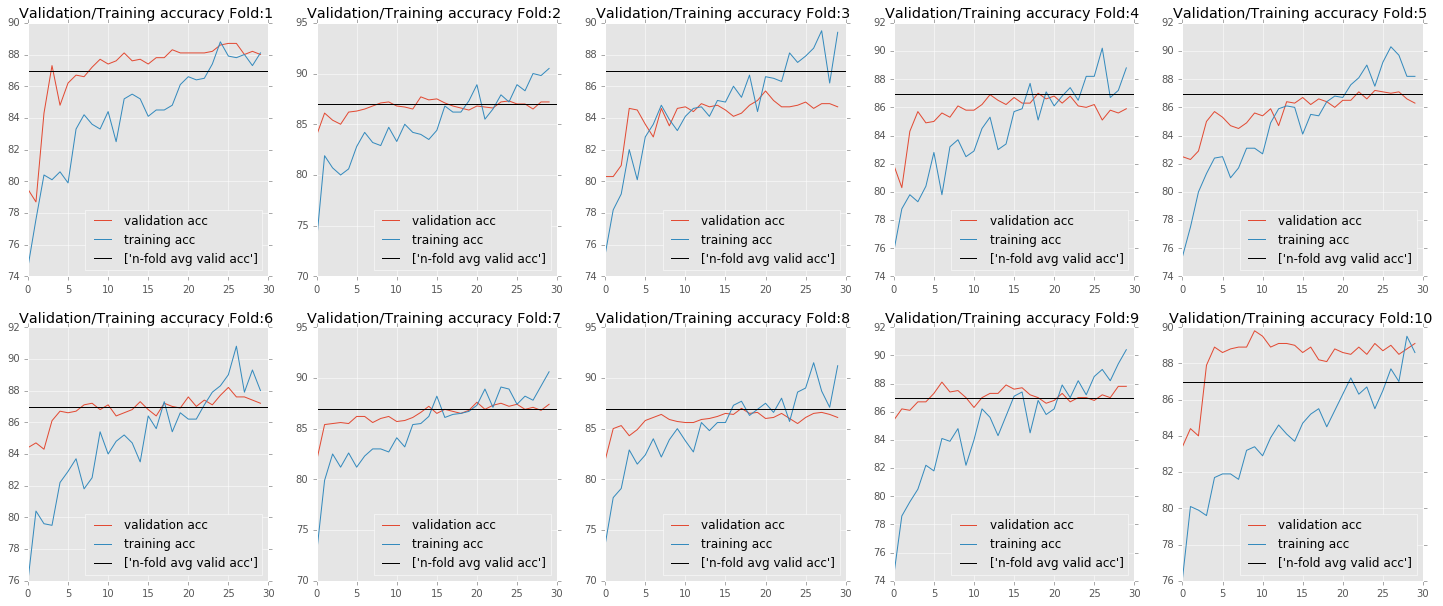

In [14]:
rows = 2
columns = 5
vizualize(vaccPerEpochPerFold, taccPerEpochPerFold, meanValidAcc=meanValidAcc, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

In [15]:
STDbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/STD/batchData/"
EDGbatch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/EDG/batchData/"
HOGp1batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp1/batchData/"   # dim =162
HOGp2batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp2/batchData/"   # dim =576
HOGp3batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp3/batchData/"
HOGp4batch_dir = "/Users/sam/All-Program/App-DataSet/Kaggle-Challenges/CIFAR-10/Model-Sardhendu/HOGp4/batchData/"

featureDIR = HOGp4batch_dir

params = dict(imageSize = 32,
              numLabels = 2,
              
              # Network params
              numHidden1 = 1024,
              numHidden2 = 1280,
              numHidden3 = 1024, 

              # Batch Variables
              numFolds = 10,
              epochs = 30,
              batchSize = 1000,
             
              # Optimization Params
              keepProb = dict(hid1=0.75, hid2=0.5, hid3=0.5),
              optimizerParam = dict(optimizer='ADAM', learning_rate=0.007)
             )

# optimizer = tf.train.AdamOptimizer(learning_rate=0.008).minimize(lossCE)

(out, meanValidAcc, lossPerEpochPerFold, taccPerEpochPerFold, vaccPerEpochPerFold) = SessionExec(featureDIR, params).execute() 

print ('The mean Valid Accuracy is : ', meanValidAcc)




##########################################################################################

Validation Data and Labels shape:  (1000, 1179) (1000, 2)
Training Data and Labels shape:  (9000, 1179) (9000, 2)
The Label Dictionary is given as:  {0: 'trainDataAirplane.pickle', 1: 'trainDataCat.pickle'}

{'optimizerParam': {'learning_rate': 0.007, 'optimizer': 'ADAM'}, 'epochs': 30, 'numHidden1': 1024, 'imageSize': 32, 'numFolds': 10, 'numLabels': 2, 'batchSize': 1000, 'numHidden2': 1280, 'keepProb': {'hid2': 0.5, 'hid1': 0.75, 'hid3': 0.5}, 'numHidden3': 1024}
Fold: 1, Epoch: 1, Mini Batch: 9, Loss= 22548.992188, Training Accuracy= 70.80000

Fold: 1, Epoch: 1, Validation Accuracy= 82.80000

Fold: 1, Epoch: 2, Mini Batch: 9, Loss= 13756.709961, Training Accuracy= 74.10000

Fold: 1, Epoch: 2, Validation Accuracy= 85.70000

Fold: 1, Epoch: 3, Mini Batch: 9, Loss= 7813.561523, Training Accuracy= 78.70000

Fold: 1, Epoch: 3, Validation Accuracy= 85.00000

Fold: 1, Epoch: 4, Mini Batch: 9, Loss=

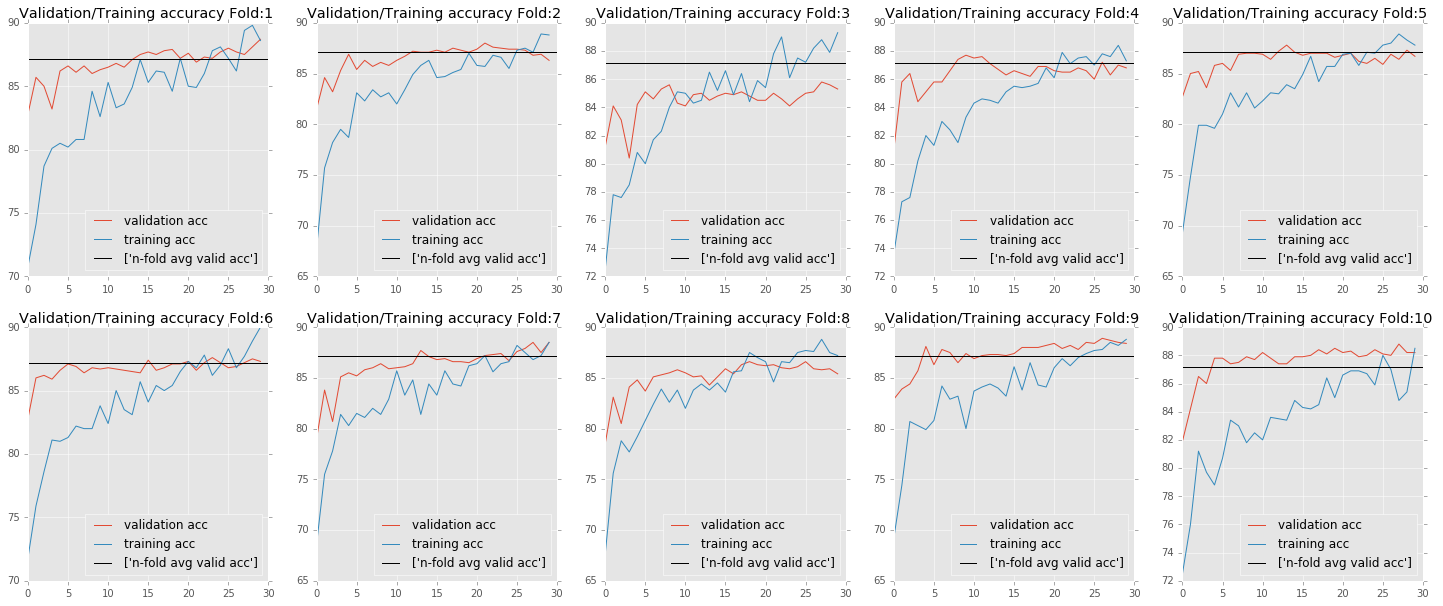

In [16]:
rows = 2
columns = 5
vizualize(vaccPerEpochPerFold, taccPerEpochPerFold, meanValidAcc=meanValidAcc, rows=rows, columns=columns, figsize=(5*columns, 5*rows))

# MODEL 2: HOG Multi-Filter with RMSPROP

In [ ]:
# self.seed = 2316
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1280
# self.numHidden3 = 1024
# self.numLabels = 2
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 50
# self.batchSize = 1000


# Fold: 1, Epoch: 50, Mini Batch: 9, Loss= 43.558125, Training Accuracy= 97.50000

# Fold: 1, Epoch: 50, Validation Accuracy= 88.30000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          452   69   521
# 1           48  431   479
# All        500  500  1000

# optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0005, momentum=0.9).minimize(lossCE) 


ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with RMS Prop:
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1280
# self.numHidden3 = 1024
# self.numLabels = 2
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 50
# self.batchSize = 1000


# Fold: 1, Epoch: 30, Mini Batch: 9, Loss= 249.902252, Training Accuracy= 92.40000

# Fold: 1, Epoch: 30, Validation Accuracy= 88.60000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          452   66   518
# 1           48  434   482
# All        500  500  1000

# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75

# optimizer = tf.train.RMSPropOptimizer(learning_rate=0.0008, momentum=0.8).minimize(lossCE)

ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with RMS Prop:
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1280
# self.numHidden3 = 1024
# self.numLabels = 2
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000

# learning_rate = 0.01
# momentum = 0.8


# Fold: 1, Epoch: 30, Mini Batch: 9, Loss= 249.902252, Training Accuracy= 92.40000

# Fold: 1, Epoch: 30, Validation Accuracy= 88.60000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          452   66   518
# 1           48  434   482
# All        500  500  1000

# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75

ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with RMS Prop:
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1280
# self.numHidden3 = 1024
# self.numLabels = 2
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000

# learning_rate = 0.01
# momentum = 0.8


# Fold: 1, Epoch: 30, Mini Batch: 9, Loss= 131.296799, Training Accuracy= 94.40000

# Fold: 1, Epoch: 30, Validation Accuracy= 87.80000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          442   64   506
# 1           58  436   494
# All        500  500  1000

# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75

ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with RMS Prop:
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1280
# self.numHidden3 = 1024
# self.numLabels = 2
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000

# learning_rate = 0.01
# momentum = 0.7


# Fold: 1, Epoch: 30, Mini Batch: 9, Loss= 332.687378, Training Accuracy= 91.20000

# Fold: 1, Epoch: 30, Validation Accuracy= 87.30000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          452   79   531
# 1           48  421   469
# All        500  500  1000

# hid1 = dropoutProb=0.5
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75

ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with RMS Prop:
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1024
# self.numHidden3 = 1024
# self.numLabels = 2
# self.momentum = 0.5        # Momentum for momentum Optimizer
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000

# learning_rate=0.001, momentum=0.8

# Fold: 1, Epoch: 30, Validation Accuracy= 86.90000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          446   77   523
# 1           54  423   477
# All        500  500  1000

# hid1 = dropoutProb=0.5
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75


ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with Adam Optimizer:

# Learning_rate = 0.001
# self.seed = 2316
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1280
# self.numHidden3 = 1024
# self.numLabels = 2
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000


# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          425   55   480
# 1           75  445   520
# All        500  500  1000


# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75

x = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer For RELU activation layer with Adam Optimizer:
# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1024
# self.numHidden3 = 1024
# self.numLabels = 2
# self.alpha = 0.001          # Learning Rate 
# self.momentum = 0.9        # Momentum for momentum Optimizer
# self.numFolds = 10

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000

# Fold: 1, Epoch: 30, Validation Accuracy= 87.70000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          421   44   465
# 1           79  456   535
# All        500  500  1000

# hid1 = dropoutProb=0.5
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75


ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()

In [ ]:
# Plotting Weight Change for every Hidden Layer for LOGIT units:

# self.imageSize = 32
# self.numHidden1 = 1024
# self.numHidden2 = 1024
# self.numHidden3 = 1024
# self.numLabels = 2
# self.alpha = 0.001          # Learning Rate 
# self.momentum = 0.9        # Momentum for momentum Optimizer
# self.numFolds = 10
# self.dropout = 0.5

# # Learning Variables     
# self.epochs = 30
# self.batchSize = 1000

# Fold: 1, Epoch: 30, Validation Accuracy= 83.10000

# Confusion Matrix CrossValid Set
# Predicted    0    1   All
# True                     
# 0          359   28   387
# 1          141  472   613
# All        500  500  1000

# hid1 = dropoutProb=0.5
# hid1 = dropoutProb=0.75
# hid1 = dropoutProb=0.75


ax = plt.figure(figsize=(40,20), facecolor='w', edgecolor='k')
legend = []
for layer, wghtchng_arr in out.items():
#     print (layer)
    prcntg_cnhg = []
    for num, chng in enumerate(wghtchng_arr[1:len(wghtchng_arr)]):
#         print (wghtchng_arr[num], chng,  abs(wghtchng_arr[num] - chng), (100* (chng/wghtchng_arr[num])), 100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
        prcntg_cnhg.append(100*(abs(chng-wghtchng_arr[num])/wghtchng_arr[num]))
    plt.plot(prcntg_cnhg)
    
    legend.append(layer) 
#     print ('')
    
plt.legend(legend, loc='upper right', fontsize=20)
plt.show()